# Spaceship Titanic
The project inspects Spaceship Titanic Dataset from Kaggle. 

The primary objectives are to clean the data, perform exploratory data analysis, statistical analysis, and apply various machine learning models for target variable Transported prediction. 

Transported predictions will uploaded to Kaggle as a competition entry, performance goal is 79% accuracy (or more).

## Dataset
Dataset can be downloaded from [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/overview).

In [146]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

%load_ext autoreload
%autoreload 2
from help_tool import help_tool


# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
pd.set_option('future.no_silent_downcasting', True)

# Data download and Cleaning
Checking for duplicates and empty values, as well as the size of dataset:

* Dataset has 8693 observations and 14 features
* Some features are missing 2% of their data
* No duplicates

In [148]:
titanic = help_tool.csv_download(r'Archive\spaceship-titanic\train.csv')
help_tool.first_look(titanic)

Dataset has 8693 observations and 14 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
PassengerId,object,0,0.0
HomePlanet,object,201,2.3
CryoSleep,object,217,2.5
Cabin,object,199,2.3
Destination,object,182,2.1
Age,float64,179,2.1
VIP,object,203,2.3
RoomService,float64,181,2.1
FoodCourt,float64,183,2.1
ShoppingMall,float64,208,2.4


In [149]:
titanic.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Feature separation
### PassengerId, Name, Cabin
Some columns have multitude of information encoded:
* PassengerId - Group and Group_Id
* Cabin: 
    * Deck - values A:G, T will be converted to integers 1-8.
    * Deck_num 
    * Side - has only 2 values S (Starboard) and P (Port), will be made to bool feature.

These features will be separated.

In [150]:
def cleaning(df):
    # PassengerId
    # Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
    df[['Group', 'Group_Id']] = df['PassengerId'].str.split('_', expand=True)

    # Name
    # Separating last name for family identifications
    df[['First_Name', 'Last_Name']] = df['Name'].str.split(' ', expand=True)

    # Cabin
    # Form deck/num/side, where side can be either P for Port or S for Starboard.
    df[['Deck', 'Deck_num', 'Side']] = df['Cabin'].str.split('/', expand=True)

    for feature in ['CryoSleep', 'VIP', 'Transported', 'Group', 'Group_Id', 'Deck_num']:
        try:
            df[feature] = df[feature].astype(int)
        except:
            df[feature] = df[feature].astype(float)

    df.drop(columns=['PassengerId', 'Name'], inplace=True)
    return df


titanic = cleaning(titanic)

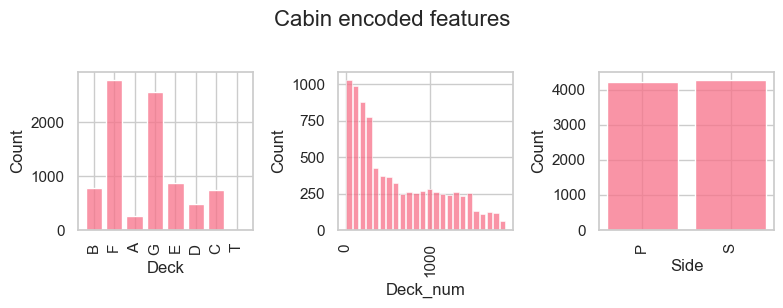

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

axes = axes.flatten()

for i, col in enumerate(['Deck', 'Deck_num', 'Side']):
    sns.histplot(data=titanic, x=col, multiple="dodge", shrink=.8,
                 ax=axes[i])
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Cabin encoded features", size=16, y=1.02)
plt.tight_layout()
plt.show()

Deck can be encoded as well as assigned a Deck_Class:
* Upper Decks (A, B, C)
* Middle Decks (D, E)
* Lower Decks (F, G)
* Service Decks (Below G)

Side has only 2 available values, only one ('S') will be left in.

In [152]:
def deck_clean(df):

    # Available Deck values are A-G, T
    df['Deck'] = df['Deck'].replace(
        {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8})

    # Deck Class
    df.loc[df['Deck'] < 4, 'Deck_Class'] = 1  # Upper Decks
    df.loc[df['Deck'].isin([4, 5]), 'Deck_Class'] = 2  # Middle Decks
    df.loc[df['Deck'].isin([6, 7]), 'Deck_Class'] = 3  # Lower Decks
    df.loc[df['Deck'] > 7, 'Deck_Class'] = 4  # Service Decks

    # Side has only 2 values and will be updated to bool feature
    df['Side'] = (df['Side'] == 'S').astype(int)

    return df


titanic = deck_clean(titanic)

### Amenities
Amenities describe how much money the passenger has paid for ship luxuries.

In [153]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

Passengers in CryoSleep are confined to their cabins, yet some of amenities values are missing. These values can be filled in with 0 (money spent).

In [154]:
titanic[titanic['CryoSleep'] == 1][amenities].isna().sum()

RoomService     68
FoodCourt       70
ShoppingMall    96
Spa             65
VRDeck          62
dtype: int64

Passangers that CryoSleep spend 0 money on amenities.

In [155]:
titanic[titanic['CryoSleep'] == 1][amenities].sum()

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

In [156]:
condition = titanic['CryoSleep'] == 1
titanic.loc[condition, amenities] = titanic.loc[condition, amenities].fillna(0)

Adding total money spent:

In [157]:
titanic['Amenities'] = titanic[amenities].sum(axis=1)

In [158]:
amenities = amenities + ['Amenities']

### Family members
People in a group are often family members, but not always. In this study, Group and Last_Name will be converted to GroupSize.

In [159]:
titanic['GroupSize'] = titanic.groupby(['Group', 'Last_Name'])[
    'Group'].transform('size')

# EDA
After feature separation, dataset has 22 features.

In [160]:
titanic.shape

(8693, 22)

Exploring feature interaction with each other. Unique features, like Cabin and Name was removed, as well as derivative features.

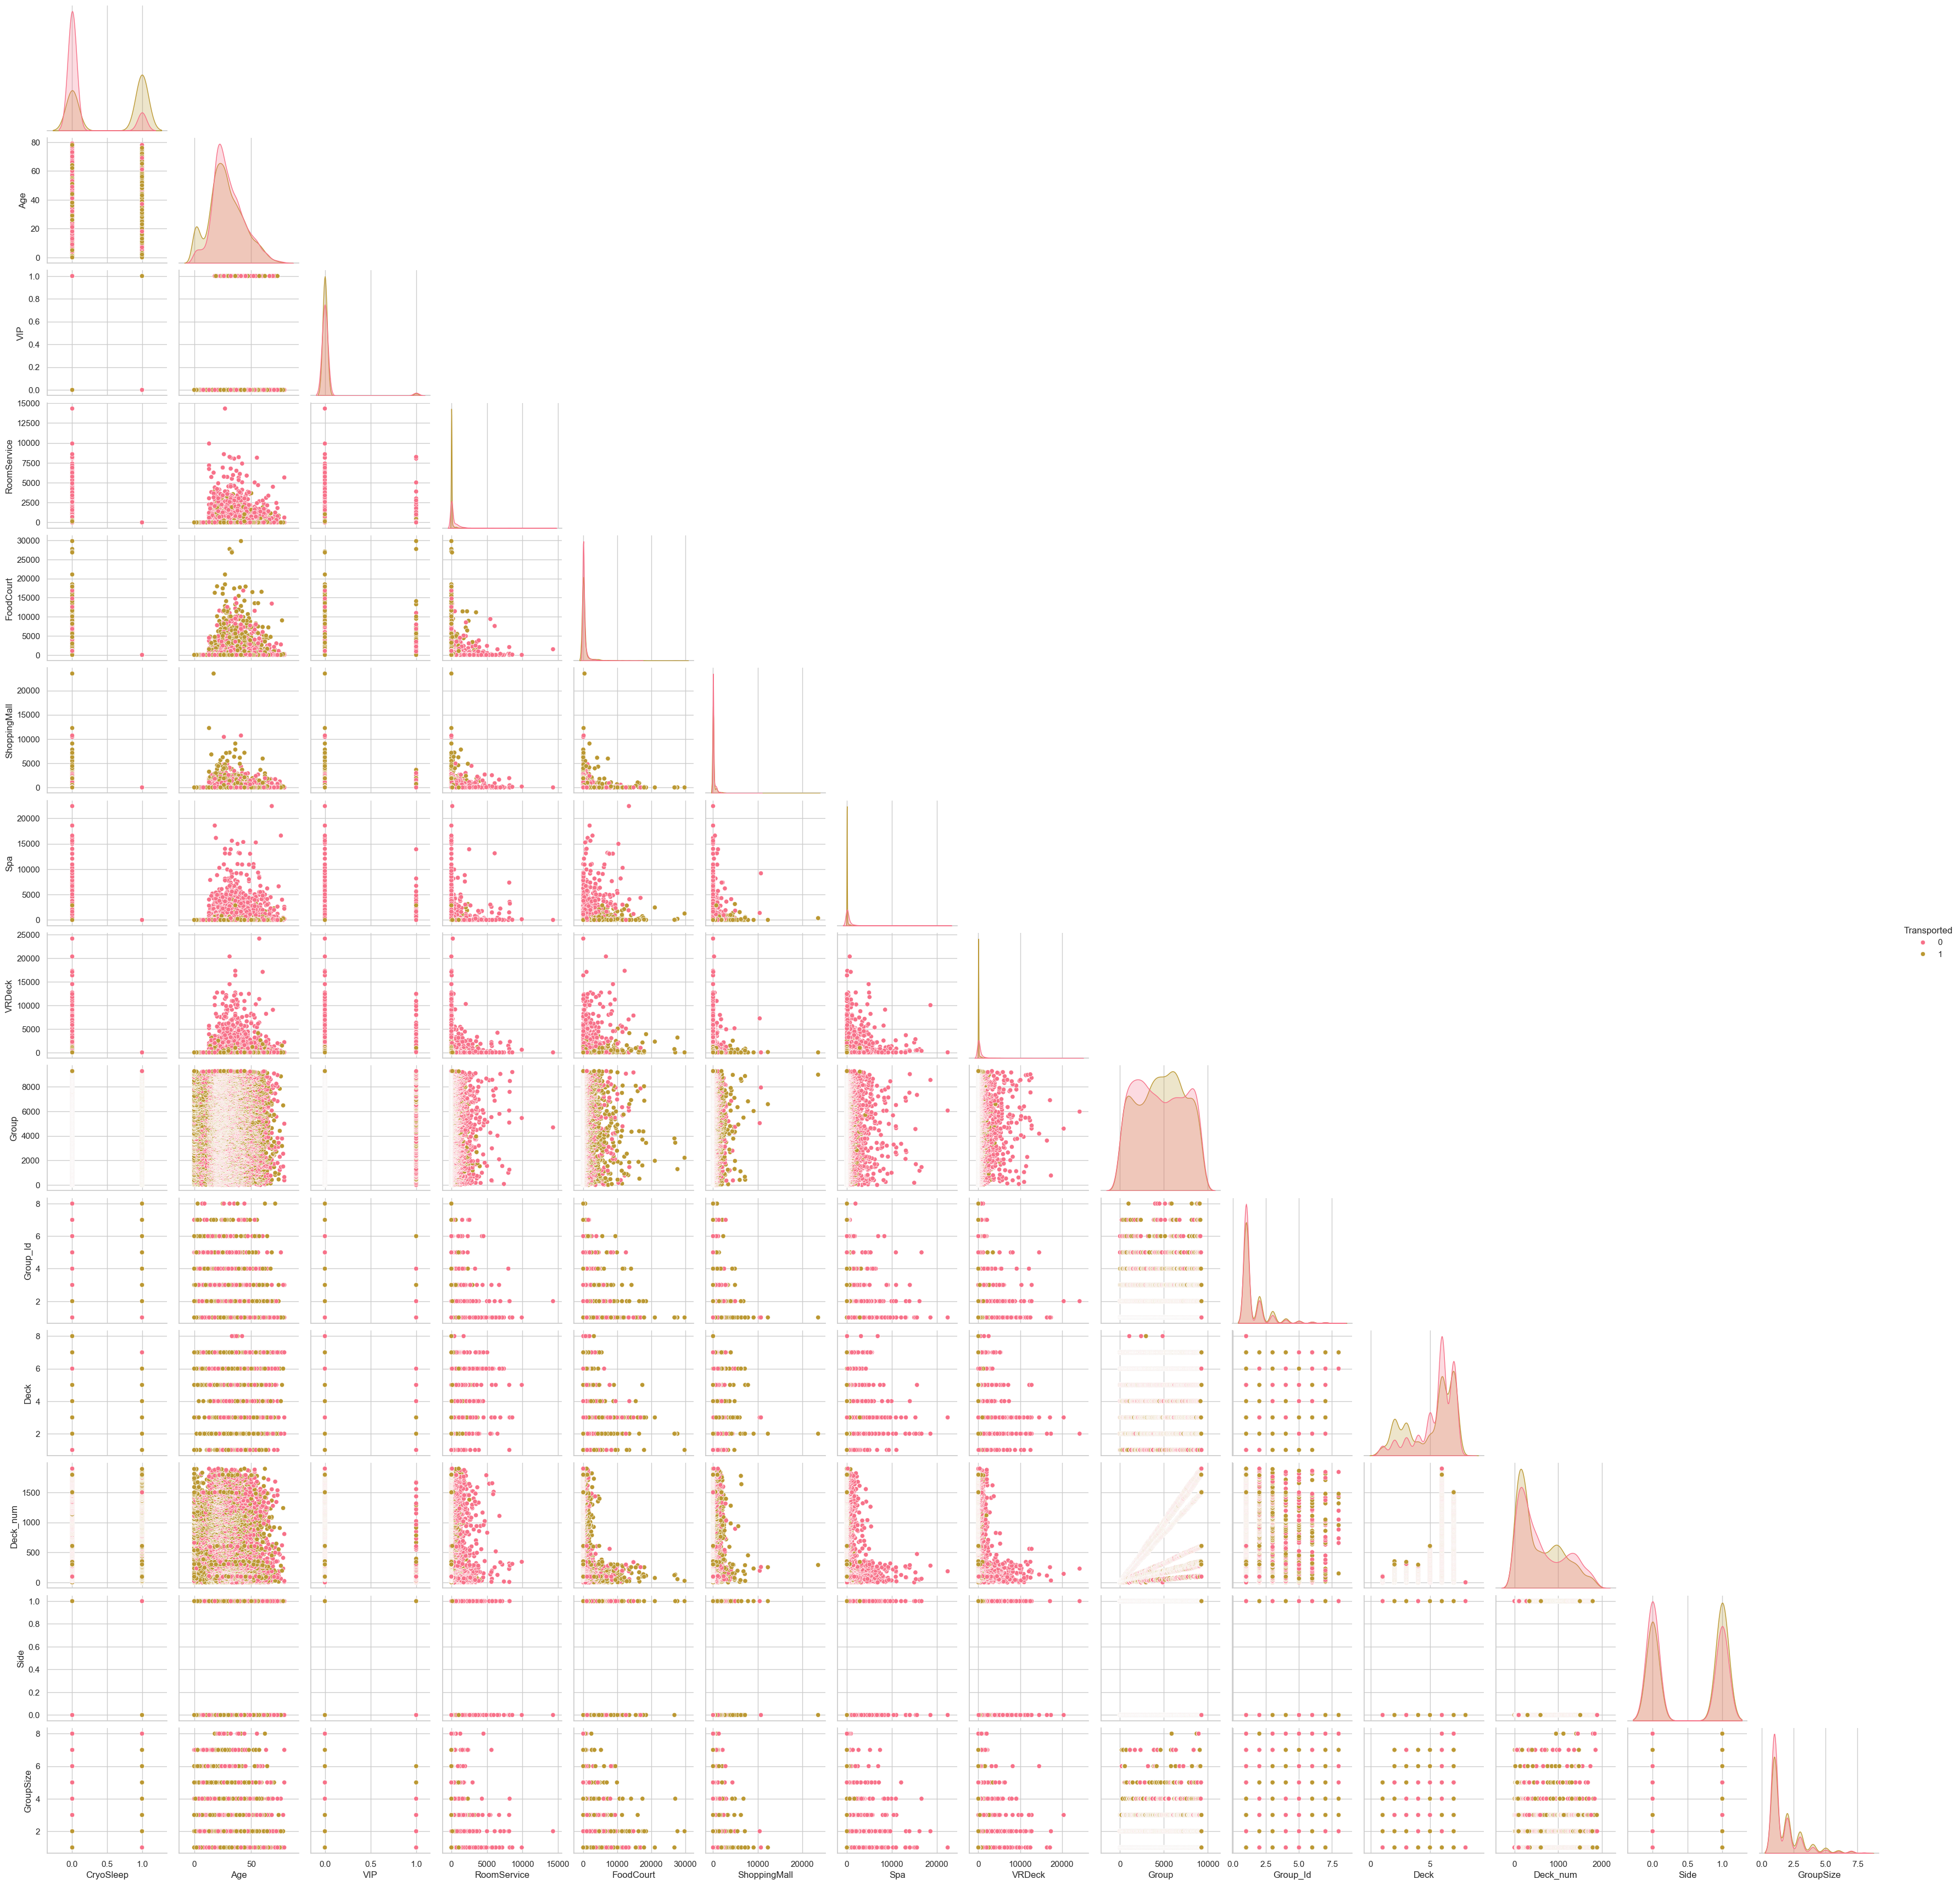

In [161]:
sns.pairplot(titanic.drop(columns=['Cabin', 'First_Name', 'Last_Name',
             'Amenities', 'Deck_Class']), corner=True, hue='Transported')
plt.show()

Conclussion:
* VIP is an imbalanced feature.
* Amenities ('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck') have similar distributions.
* Group is a unique ID-like feature.
* All groups are made of 8 or less passengers.
* Lower decks had most passengers.
* Dec_num is a unique ID-like feature and depends on Group.

Amenities are log distributed and will be log transformed to make them normaly distributes.

In [162]:
titanic_log = titanic.copy()

titanic_log[amenities] = np.log1p(titanic_log[amenities])

## Continues features
Continues features are made of:
* Amenities in Spaceship: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck look log distributed and will be log transformed.
* Age - which ranges 0-79 years. With median mid 20s. Outliers are above ~65, but it's not uncommon for people up to 80 to travel and these will be left in.
* Group 
* Deck_num

Age


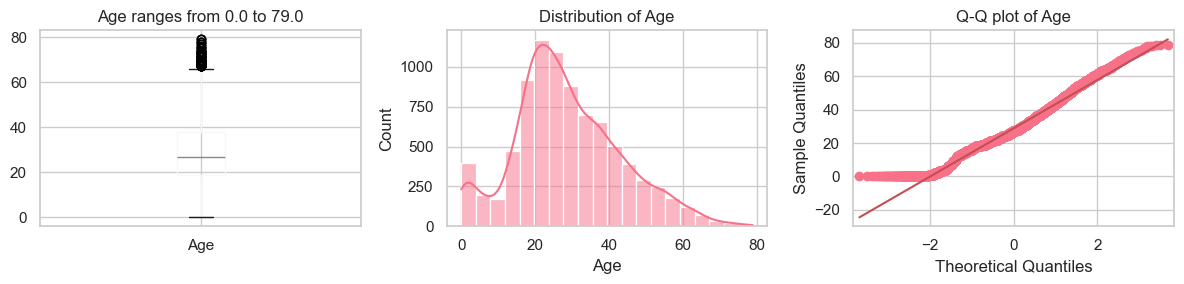

Group


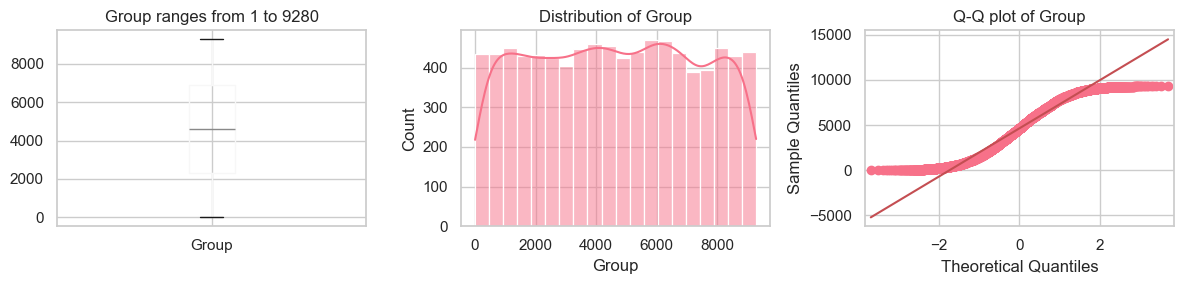

Deck_num


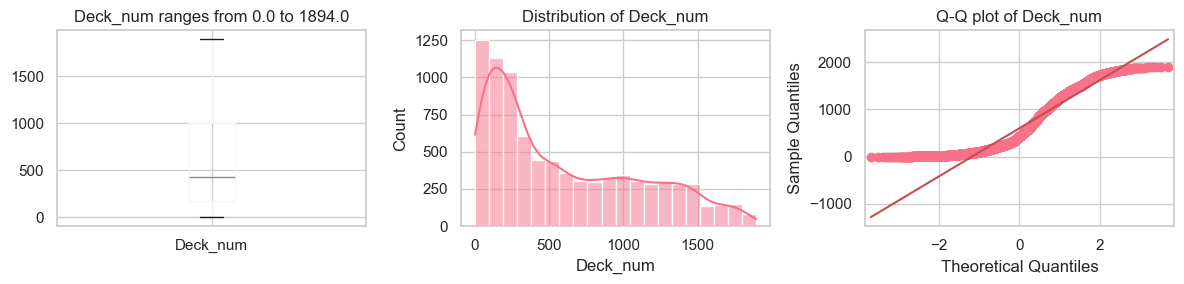

RoomService


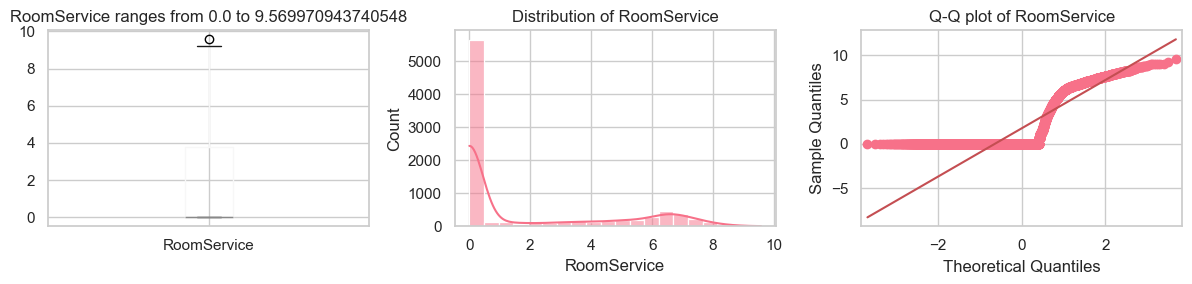

FoodCourt


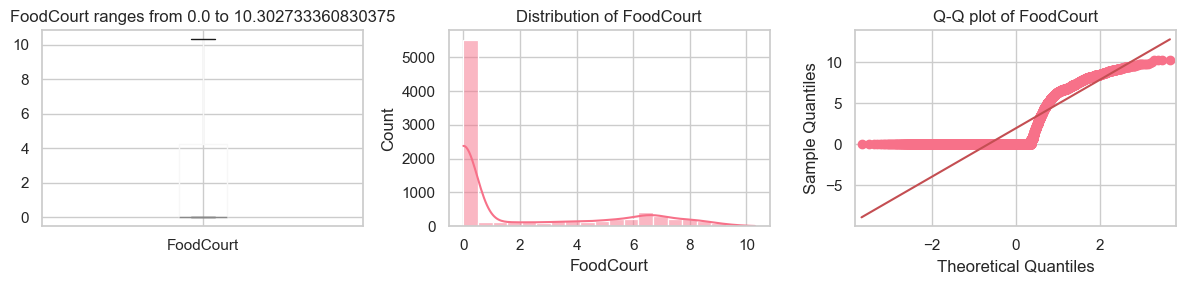

ShoppingMall


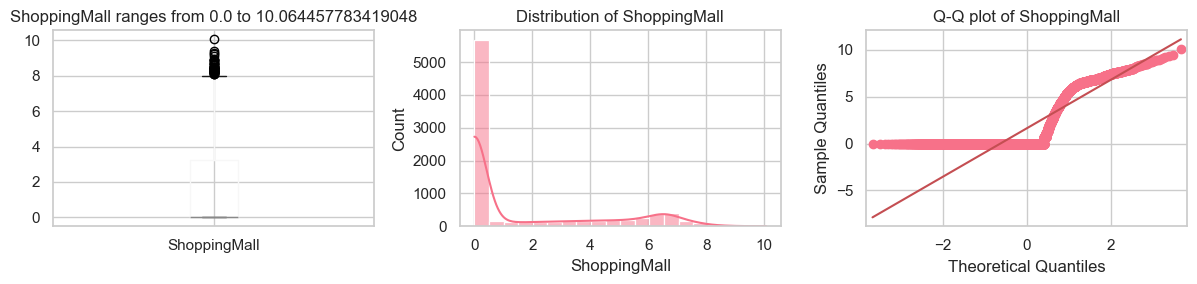

Spa


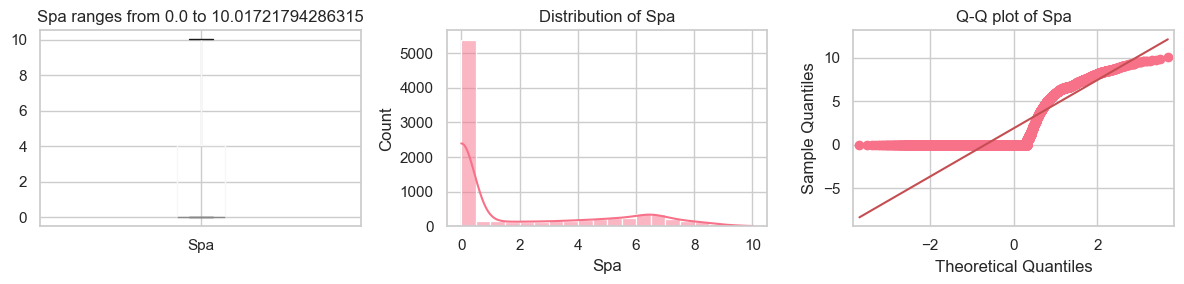

VRDeck


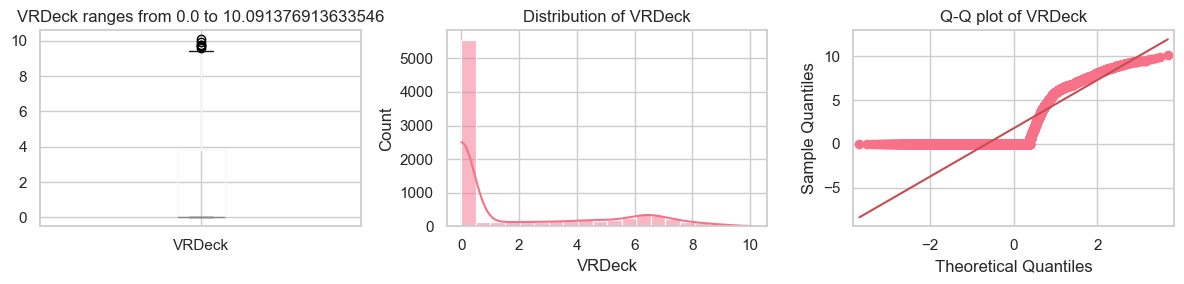

Amenities


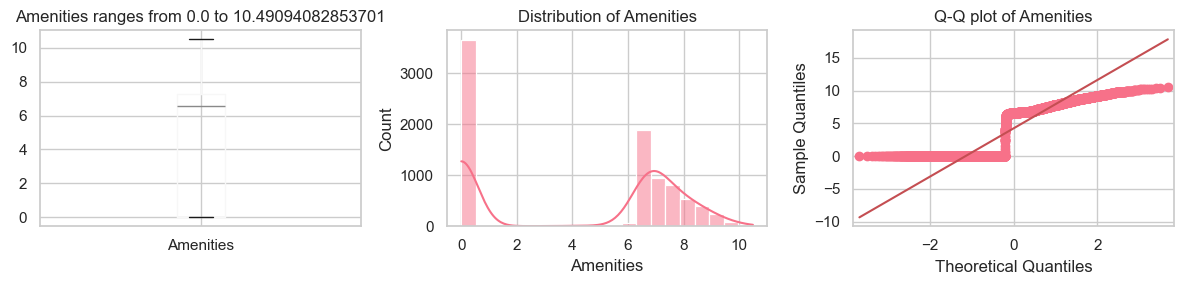

In [163]:
continuous_features = ['Age', 'Group', 'Deck_num'] + amenities

help_tool.distribution_check(titanic_log[continuous_features])

After logarithmic transformation, Amenities are still not normally distributed, as a lot of values are 0. Note, people in CryoSleep are not buying amenities. This means, that amenities are partially dependent on CryoSleep feature.

### Correlation

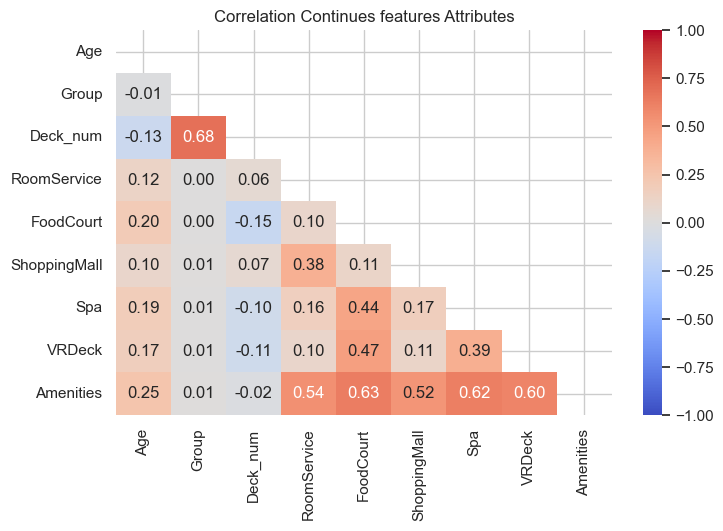

In [164]:
help_tool.heatmap(titanic_log[continuous_features],
                  'Continues features', 'pearson')

Continues features have Moderate Positive Correlation (0.3 ≤ r < 0.7) among themselves:
* As seen in PairPlot, Deck_num and Group are related.
* VRDeck and Spa have Moderate correlation with FoodCourt.
* Group is part of passenger identification and will not be used in model training.
* Amenities feature is a sum of all other amenities, thus is dependencies with other amenities.

Group have unique combinations for Deck_num and Deck, which depend on one another.

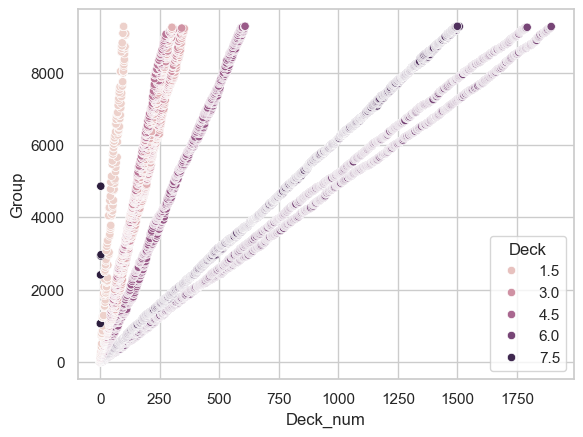

In [165]:
sns.scatterplot(titanic, x="Deck_num", y="Group", hue="Deck")
plt.show()

### Age and Amenities
People under 13 years old don't bie amenities purchase.

In [166]:
titanic[titanic['Amenities'] != 0][['Age', 'Amenities']].min()

Age          13.0
Amenities     1.0
dtype: float64

In [167]:
condition = titanic['Age'] < 13
titanic.loc[condition, amenities] = titanic.loc[condition, amenities].fillna(0)

### CryoSleep and Amenities
Peoples spending partially represent their CryoSleep state.

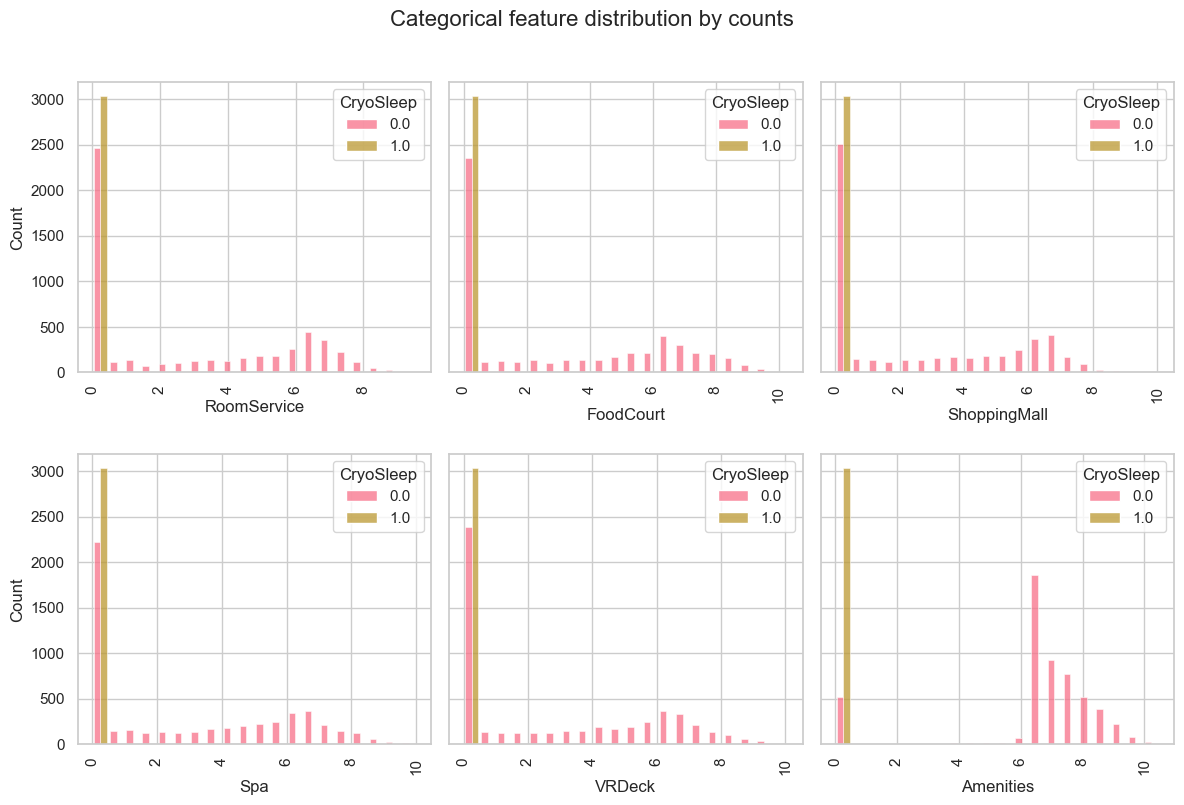

In [168]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)

axes = axes.flatten()

for i, col in enumerate(amenities):
    sns.histplot(data=titanic_log, x=col, bins=20, multiple="dodge", shrink=.8,
                 ax=axes[i], hue='CryoSleep', legend=True)
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

### Single Person Spending
Who are the people that don't spend money and are not in CryoSleep?

Constructing new features describing Single Person spending

In [169]:
for feature in amenities:
    titanic[f'Avg_{feature}'] = titanic.groupby(['Group', 'GroupSize'])[
        feature].transform('mean')


amenities_per_person = ['Avg_RoomService', 'Avg_FoodCourt', 'Avg_ShoppingMall',
                 'Avg_Spa', 'Avg_VRDeck']

titanic_log[amenities_per_person] = np.log1p(titanic[amenities_per_person])

Accounting for all the people who are not spending due to not being able. After that, a minority of people 104/8693 are left. It's safe to say, most people spend money on Titanic (if they can).

In [170]:
not_spending = titanic[(titanic['CryoSleep'] == 0) & (
    titanic['Amenities'] == 0) & (titanic['Age'] > 13)]
not_spending.shape

(104, 28)

## Categorical features
Categorical features are made of:
* Places (HomePlanet, Destination, Deck, Side). 
* Group description (Deck_Class, GroupSize) what were derived from other features. 
* CryoSleep and VIP describe passanger stay.

In [171]:
category_features = ['HomePlanet', 'Destination',
                     'Deck', 'Group_Id', 'Deck_Class', 'GroupSize']
binary_features = ['CryoSleep', 'VIP', 'Transported', 'Side']

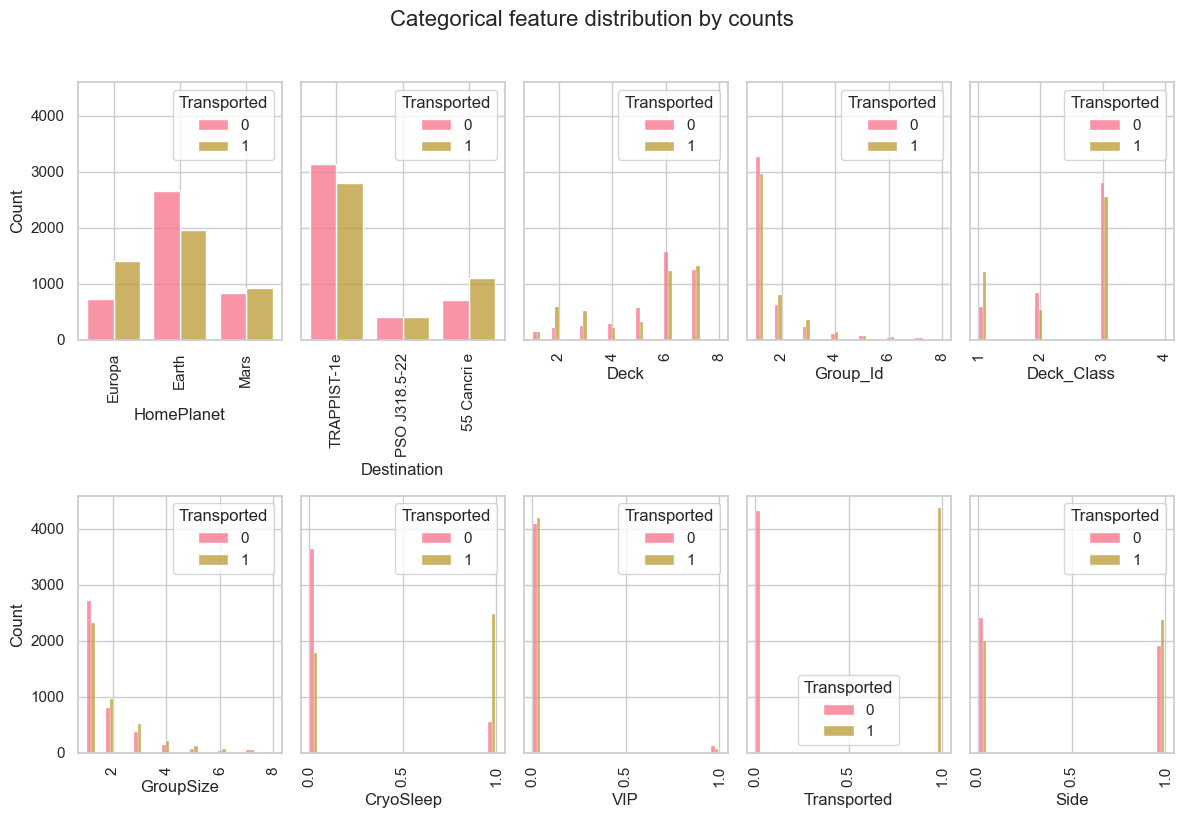

In [172]:
fig, axes = plt.subplots(2, 5, figsize=(12, 8), sharey=True)

axes = axes.flatten()

for i, col in enumerate(category_features + binary_features):
    sns.histplot(data=titanic, x=col, bins=20, multiple="dodge", shrink=.8,
                 ax=axes[i], hue='Transported', legend=True)
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

* Most passengers are from Earth, but also Europa and Mars (Solar System).
* 3 destinations, with most popular - TRAPPIST-1e
* Most passengers stay in lower decks (with Deck_class being a derived feature).
* Most passengers are in Groups of 1-2 people
* Target feature Transported seams balanced
* VIP is imbalanced.

### Distance encoding
Distances from Earth to:
* Earth to Mars: 7.5 light minutes.
* Earth to Europa: 40 light minutes.

* Earth to TRAPPIST-1e: Approximately 39 light-years away.
* Earth to 55 Cancri e: Approximately 41 light-years away.
* Earth to PSO J318.5-22: Approximately 80 light-years away. 

PSO J318.5-22 is a rogue planet, not bound to any star. Its distance is not directly comparable in terms of solar distances, as it floats in the vastness of space without orbiting a star like the others.

* encoding 'HomePlanet', 'Destination' with numbers for correlation check

In [173]:
def planet_encoding(df):
    df.loc[df['HomePlanet'] == 'Earth', 'HomePlanet_Encoded'] = 1
    df.loc[df['HomePlanet'] == 'Mars', 'HomePlanet_Encoded'] = 2
    df.loc[df['HomePlanet'] == 'Europa', 'HomePlanet_Encoded'] = 3

    df.loc[df['Destination'] == 'TRAPPIST-1e', 'Destination_Encoded'] = 1
    df.loc[df['Destination'] == '55 Cancri e', 'Destination_Encoded'] = 2
    df.loc[df['Destination'] == 'PSO J318.5-22', 'Destination_Encoded'] = 3

    return df


titanic = planet_encoding(titanic)

### VIP 
VIP variance is 2.3% for minority class 1. Let's check if there's a significant relationship to target feature Transported

In [174]:
titanic['VIP'].var() * 100

2.289263414540038

Null Hypothesis (H0): There is no relationship between 'VIP' and 'Transported'. <br>
Alternative Hypothesis (H1): There is a relationship between 'VIP' and 'Transported'.

In [175]:
help_tool.chi_squared_test(titanic, ('VIP', 'Transported'))

Chi-squared statistic: 11.542020738162797. P-value: 0.0006804064556968345. Reject the null hypothesis.


A lot of VIP values are missing, let's check the profile of VIP passenger:
* 95% confidence interval for VIP age is 35-39 years old and not overlapping with non VIP age (28).

In [176]:
print('VIP: ')
help_tool.confidence_intervals(
    titanic[titanic['VIP'] == 1]['Age'], 'Continuous')
print('NOT VIP: ')
help_tool.confidence_intervals(
    titanic[titanic['VIP'] == 0]['Age'], 'Continuous')

VIP: 
Confidence Interval: [35.84, 39.06]
NOT VIP: 
Confidence Interval: [28.33, 28.95]


* VIP passengers spent >50% more money on amenities

In [177]:
print('VIP: ')
help_tool.confidence_intervals(
    titanic[titanic['VIP'] == 1]['Amenities'], 'Continuous')
print('NOT VIP: ')
help_tool.confidence_intervals(
    titanic[titanic['VIP'] == 0]['Amenities'], 'Continuous')

VIP: 
Confidence Interval: [3713.93, 5137.02]
NOT VIP: 
Confidence Interval: [1313.74, 1429.27]


Do VIP passengers spent significantly more money (alpha = 0.05) on individual amenities?

Null Hypothesis: VIP passengers don't spent significantly more money on Amenities.<br>
Alternative Hypotheses: VIP passengers spent significantly more money on Amenities.

In [178]:
for feature in amenities:
    help_tool.significance_t_test(titanic, feature, 'VIP', 0, 1)

p-value = nan between RoomService and VIP. Fail to reject null hypothesis
p-value = nan between FoodCourt and VIP. Fail to reject null hypothesis
p-value = nan between ShoppingMall and VIP. Fail to reject null hypothesis
p-value = nan between Spa and VIP. Fail to reject null hypothesis
p-value = nan between VRDeck and VIP. Fail to reject null hypothesis
p-value = 0.0000 between Amenities and VIP. Reject null hypothesis


* VIP passengers spent significantly more money on amenities overall, but not on any one amenity.

Do VIP passengers come from/ to a specific planet or are staying in a specific Deck?

Null Hypothesis: VIP passengers have no dependency on HomePlanet, Destination or Deck.<br>
Alternative Hypotheses: Some HomePlanet, Destination or Deck have significant more VIP passengers.

In [179]:
for feature in ['HomePlanet', 'Destination_Encoded', 'Deck_Class']:
    help_tool.significance_t_test(titanic, feature, 'VIP', 0, 1)

p-value = nan between HomePlanet and VIP. Fail to reject null hypothesis
p-value = nan between Destination_Encoded and VIP. Fail to reject null hypothesis
p-value = nan between Deck_Class and VIP. Fail to reject null hypothesis


* VIP passengers come from each of 3 planets, independent of destination and Deck location.

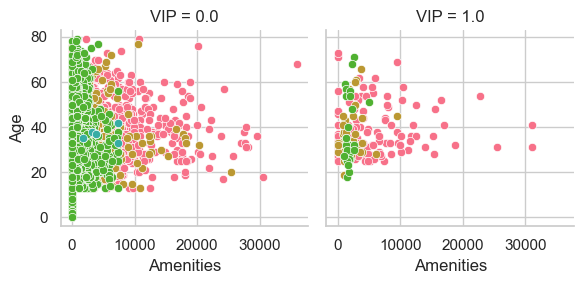

In [180]:
g = sns.FacetGrid(titanic, col="VIP", hue='Deck_Class')
g.map(sns.scatterplot, "Amenities", "Age")

plt.show()

There's no clear way of imputing VIP:
* All Deck Classes apply for VIP
* 35-39 years old if 95% confidence of VIP, but the age distribution is spread.

### Correlation

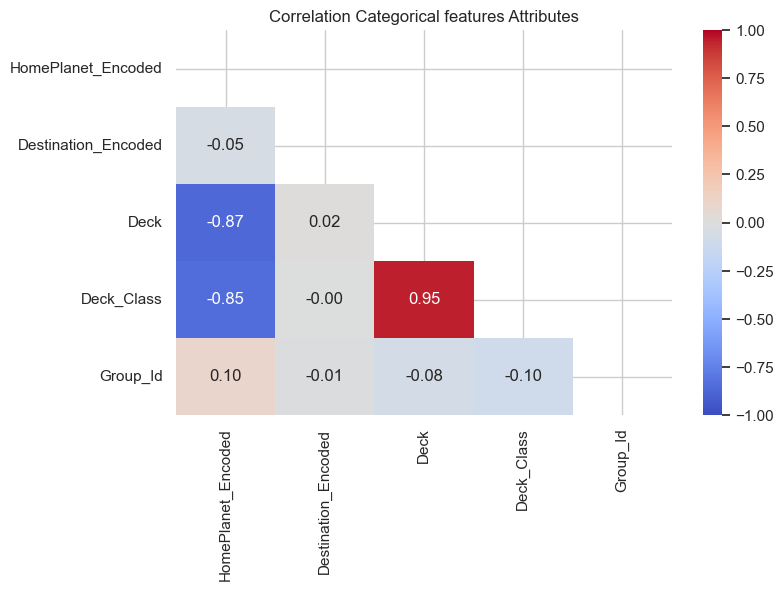

In [181]:
help_tool.heatmap(titanic[['HomePlanet_Encoded', 'Destination_Encoded',
                  'Deck', 'Deck_Class', 'Group_Id']], 'Categorical features', 'pearson')

* Deck and homeplanet are correlated negatively. One of them will be removed from modeling.

### Homeplanet and living area
Homeplanet determines deck living area:
* Europa: 1-5
* Mars: 4-6
* Earth: 5-7

Desc living are is filled Europo - Mars -Earth

<Figure size 1200x800 with 0 Axes>

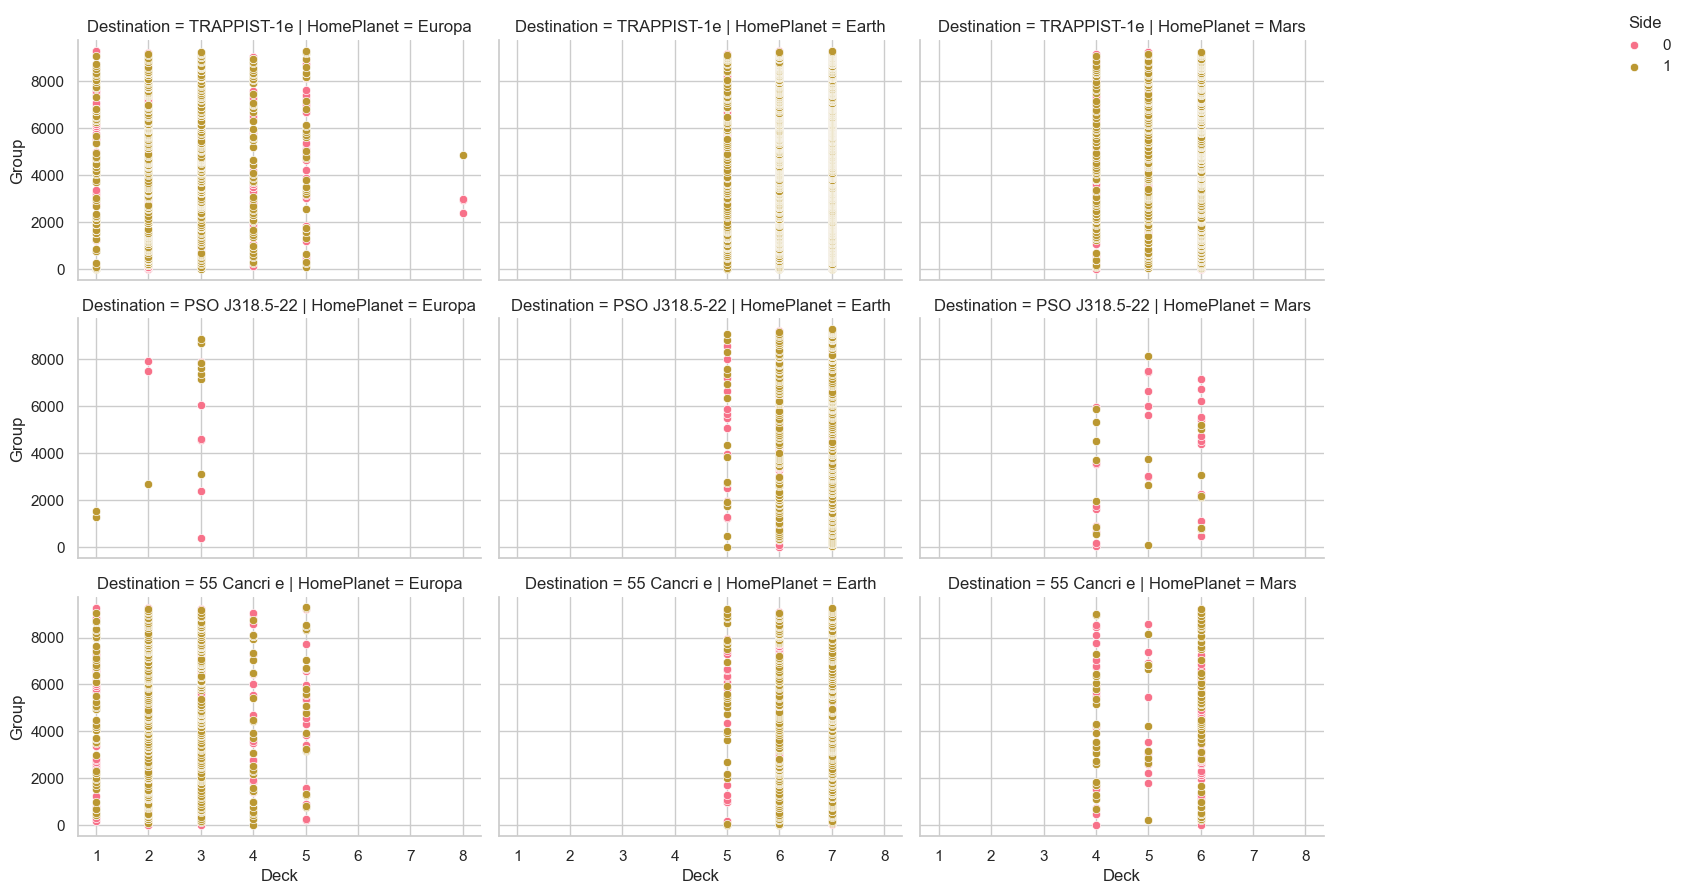

In [182]:
plt.figure(figsize=(12, 8))

g = sns.FacetGrid(titanic, row="Destination", col="HomePlanet",
                  hue='Side', height=3, aspect=1.5)

g.map(sns.scatterplot, "Deck", "Group")

g.add_legend(loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

Filling in missing HomePlanet with new finding

In [183]:
def filling_homeplanet(df):
    df.loc[df['HomePlanet'].isna() & ((df['Deck'] < 4) | (
        df['Deck'] == 8)), 'HomePlanet'] = 'Europa'
    df.loc[df['HomePlanet'].isna() & (df['Deck'] == 7), 'HomePlanet'] = 'Earth'

    return df


filling_homeplanet(titanic)

titanic[titanic['HomePlanet'].isna()]['Deck'].value_counts()

Deck
6    70
5    23
4    10
Name: count, dtype: int64

## Binary features
Binary features need separate attention when checking their correlation agains each other. Phi Correlation was chosen.

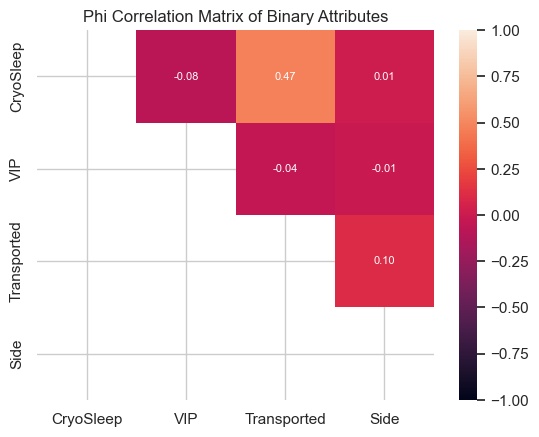

In [184]:
help_tool.phi_corr_matrix(titanic.dropna(), binary_features)

* CryoSleep and Transported is somewhat correlated.

# All features
Checking binary and other feature correlation against each other.

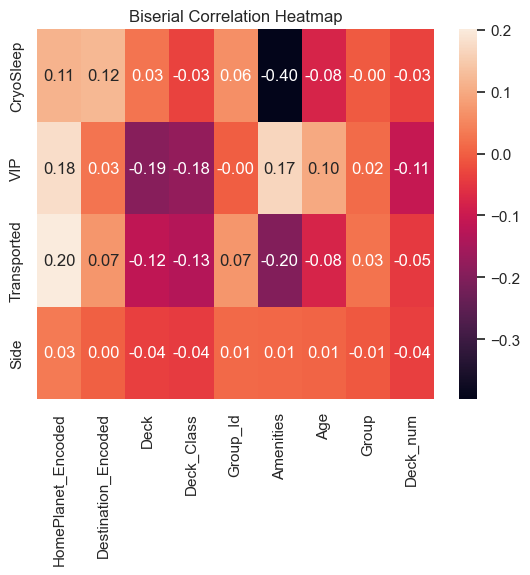

In [186]:
continues_transformed = ['HomePlanet_Encoded', 'Destination_Encoded',
                         'Deck', 'Deck_Class', 'Group_Id', 'Amenities', 'Age', 'Group', 'Deck_num']

help_tool.biserial_heatmap(titanic.dropna(), continues_transformed, binary_features)

Biserial correlation shows there's no correlation among binary and other features.

# Missing data
People in a group are often family members, but not always. Let's assume family members with same group and Last Name also share HomePlanet, Cabin and Destination.

In [187]:
def missing_value(df, feature):
    df.sort_values(['Last_Name', 'Group', feature], inplace=True)
    groups = df.groupby(['Last_Name', 'Group'])

    for (last_name, group), group_df in groups:
        feature_finding = group_df[feature].dropna(
        ).iloc[0] if not group_df[feature].isnull().all() else None

        mask = (df['Last_Name'] == last_name) & (df['Group'] == group)
        df.loc[mask, feature] = feature_finding

    df.reset_index(drop=True, inplace=True)

    return df


for i in ['HomePlanet', 'Cabin', 'Destination']:
    titanic = missing_value(titanic, i)

In [188]:
titanic = help_tool.cabin_split(titanic)
titanic = planet_encoding(titanic)

In [189]:
titanic_filtered = titanic.copy()
titanic_filtered[amenities] = titanic_log[amenities]

In [190]:
titanic_filtered.drop(columns=['Cabin', 'First_Name', 'Last_Name',
                      'Group', 'Group_Id', 'HomePlanet', 'Destination'], inplace=True)

Filling in categorical values with mode

In [191]:
# Fill missing values for specified columns using mode
for i in ['CryoSleep', 'VIP', 'HomePlanet_Encoded', 'Transported', 'Deck_Class',
          'Deck', 'Side', 'HomePlanet_Encoded', 'Destination_Encoded',
          'GroupSize']:
    mode_value = titanic_filtered[i].mode()[0]
    titanic_filtered.loc[titanic_filtered[i].isnull(), i] = mode_value

Filling in Continues values with mean

In [192]:
# Fill missing values for specified columns with mean
columns_to_fill = ['Age', 'Deck_num'] + amenities + amenities_per_person
titanic_filtered[columns_to_fill] = titanic_filtered[columns_to_fill].fillna(
    titanic_filtered[columns_to_fill].mean())

# Mutal Information gain

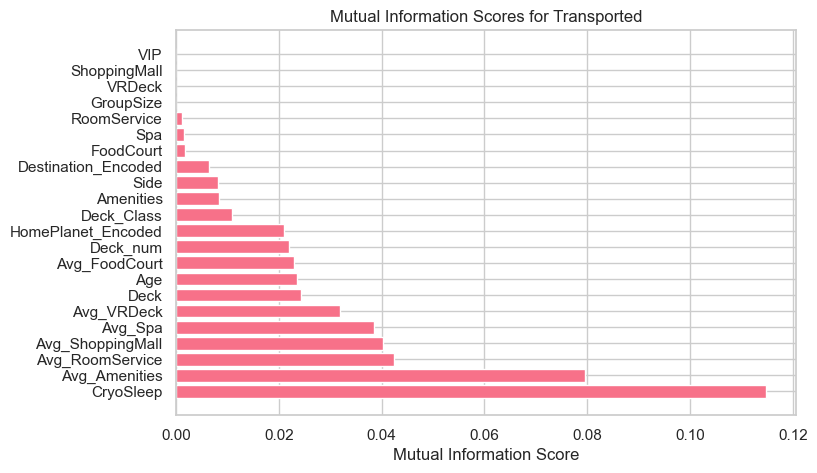

In [193]:
X = titanic_filtered.drop(['Transported'], axis=1)
y = titanic_filtered['Transported']

# Compute mutual information scores
mi_scores = pd.DataFrame(mutual_info_classif(
    X, y), index=X.columns, columns=['Mutual Information Gain'])
mi_scores.sort_values(by='Mutual Information Gain',
                      ascending=False, inplace=True)

# Visualize the scores
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)

plt.figure(dpi=100, figsize=(8, 5))
plt.barh(width, mi_scores['Mutual Information Gain'])
plt.yticks(width, ticks)
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information Scores for Transported")
plt.show()

Mutual information gain shows that:
* CryoSleep has the biggest impact on guessing Transported event.
* Newly constructed Average amenities features have more mutual information than original features.
* Deck is more important that HomePlanet.

# Conclusion
* Analasis showed that Passanger Deck depends on HomePlanned, while lower decks have most passangers. Some passangers get arround to amenities, while some sleep in CryoSleep. 
* Target demographic is mid 20s, but are in ranges of infant to 79 years old.
* Dataset has derivative features: HomePlanet and Deck
* Amenities features partially describe CryoSleep, as sleeping passengers don't get amenities. 
* Spending per person has more mutual information than single person spending.
* CryoSleep is moderately correlated with the target feature.
* Some newly created features, like Deck_Class were not useful.